In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv

# Birth Death Reaction

$ \varnothing \stackrel{k_1}\longrightarrow M $

$ M \stackrel{k_2}\longrightarrow \varnothing $

BUT: reaction rate constants are not the rates of the chain, death rate is proportional to the number of molecules = $ k_2 * m $

# Simulation: Paths and Bootstrap

In [2]:
def sample_path(x0, params, tmax, plot=False):
    """
    Simulate sample path of birth death reaction

    x0 = initial state
    params = [k1, k2]
    tmax = time of simulation

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    if plot:
        plt.step(jump_times, path, where="post")

    return path, jump_times

In [3]:

def bootstrap(x_list, x0, params, tmax, n, N, plot=False, printing=False):
    """
    x_list = states to calculate probabilities for
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax, plot=plot)
        states.append(path[-2])
    if plot:
        plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

### Test

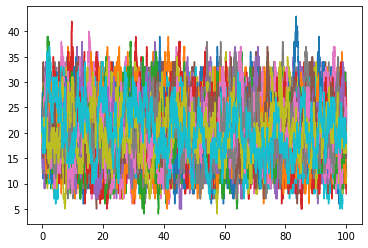

95% CI for p(19) is: (0.02, 0.15)


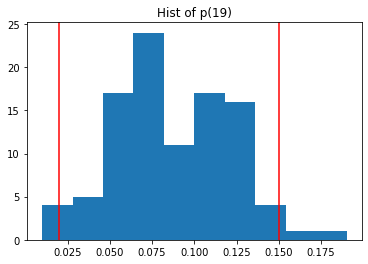

95% CI for p(20) is: (0.04, 0.16049999999999984)


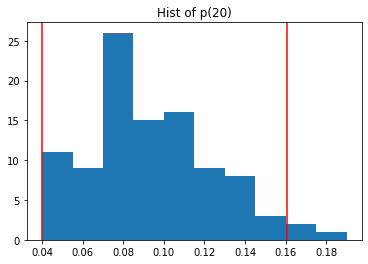

95% CI for p(21) is: (0.02475, 0.11524999999999991)


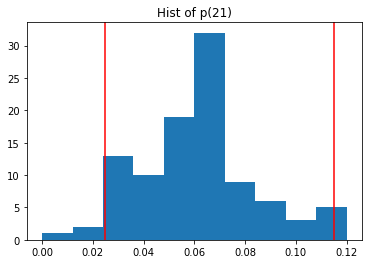

In [4]:
bootstrap([19,20,21],20,[20,1],100,100,100,plot=True,printing=True);

# Confidence Intervals: Width v True value

Plot relationship between width of bootstrapped confidence intervals and true value of stationary probabilities:

width $ \propto $ p(1-p), where p is the true prob

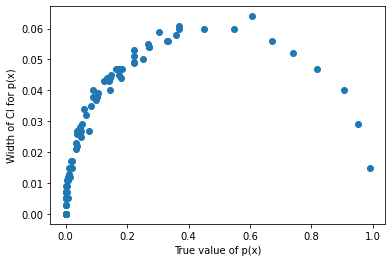

In [6]:
def width(intervals):
    return [interval[1] - interval[0] for interval in intervals]

# estimate 
x_max = 10
k2 = 1
true_p = []
variance = []
#for k1 in np.linspace(0,10,100):
for k1 in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,5]:
    estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,1000,1000)
    # compute widths of intervals
    widths = width(intervals)
    variance.extend(widths)
    # plot against true stat dist
    dist = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_max)]
    true_p.extend(dist)
plt.scatter(true_p,variance)
plt.xlabel("True value of p(x)")
plt.ylabel("Width of CI for p(x)")
plt.show()

# Create LP

In [25]:
def birth_death_LP(indices, pl, pu, printing=False):
    """
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    pl = array of lower bounds on p (enough for equations used)
    pu = array of upper bounds on p ( == )

    returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Construct the problem.
    k1 = cv.Variable(1)
    k2 = 1
    z1 = cv.Variable(N + 1)
    z2 = cv.Variable(N + 1)
    objective_max = cv.Maximize(k1)
    objective_min = cv.Minimize(k1)
    constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                z1 >= k1 * pl,
                z1 <= k1 * pu,
                z2 >= k2 * pl,
                z2 <= k2 * pu]
    prob_max = cv.Problem(objective_max, constraints)
    prob_min = cv.Problem(objective_min, constraints)   

    # Print result.
    result_max = prob_max.solve()
    if printing:
        print("\nThe upper bound is", prob_max.value)
        print("A solution k1 is")
        print(k1.value)
    max_bound = k1.value
    result_min = prob_min.solve()
    if printing:
        print("\nThe lower bound is", prob_min.value)
        print("A solution k1 is")
        print(k1.value)
    min_bound = k1.value
    
    return prob_min.value, prob_max.value

## Test

In [90]:
# create confidence intervals
k1 = 5
x_max = 12
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,2000,2000)

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# use as bounds for BD LP
lb, ub = birth_death_LP([0,1,2,8,9,10],pl,pu,printing=True)


The upper bound is 6.2818791947654065
A solution k1 is
[6.28187919]

The lower bound is 3.8291457280172945
A solution k1 is
[3.82914573]


# Width of solution interval v equation used

Equation n (row n of Q) involves p(n-1), p(n), p(n+1). As seen, the width of bounds on p depends on their true values.

- plot width of solution bounds against the single equation used to solve the LP

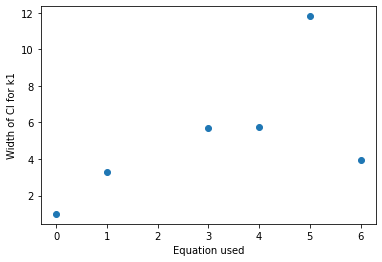

In [27]:
k1 = 2
solution_width = []
equation = []
# repeat for 10 data simulations
for k in range(1):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],0,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # using equation n: solve LP
    for n in range(8):
        lb, ub = birth_death_LP([n],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(n)
        except TypeError:
            print(f"Type error for equation {n}, ub {ub}, lb {lb}")
    # plot line for each simulation
    plt.scatter(equation,solution_width)
plt.xlabel("Equation used")
plt.ylabel("Width of CI for k1")
#dist = [100 * (k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(10)]
#plt.plot(dist)
plt.show()

### Bounds of solution v equation used

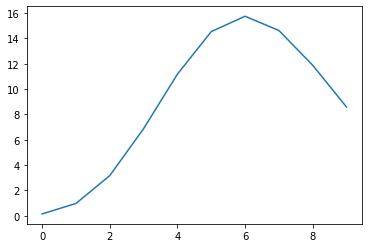

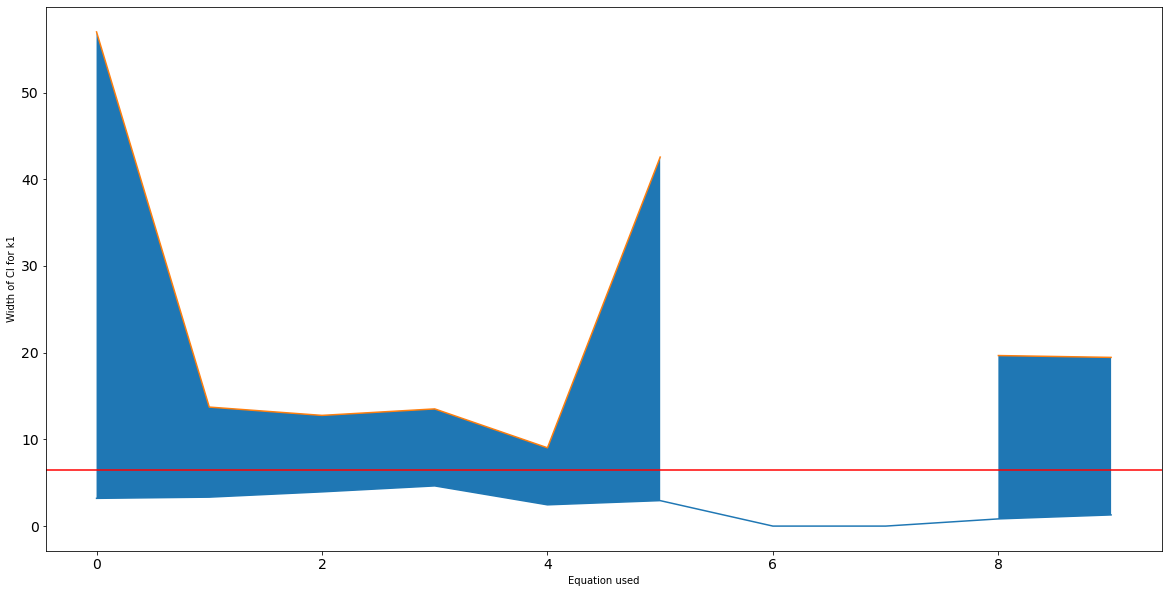

In [106]:
k1 = 6.5
ubs = []
lbs = []
equation = []
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],0,[k1,1],100,5000,5000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# using equation n: solve LP
for n in range(10):
    lb, ub = birth_death_LP([n],pl,pu)
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
dist = [100 * (k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(10)]
plt.plot(dist)

fig, ax = plt.subplots(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.xlabel("Equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")

# Investigate Best Equation to use

Simulate above many times, find the single equation

# Multiple equations

In practice will use multiple equations, usually as many as possible, so want to see how many is enough.

- simulate bounds
- solve LP using 1st equation, 1st and 2nd eqns, ...
- plot plot width of solution onterval against total # used
- repeat for several bounds to see trend

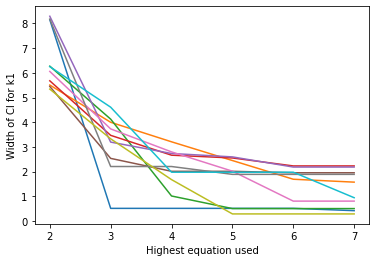

In [46]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(2,8):
        lb, ub = birth_death_LP([x for x in range(n)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(n)
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
plt.show()

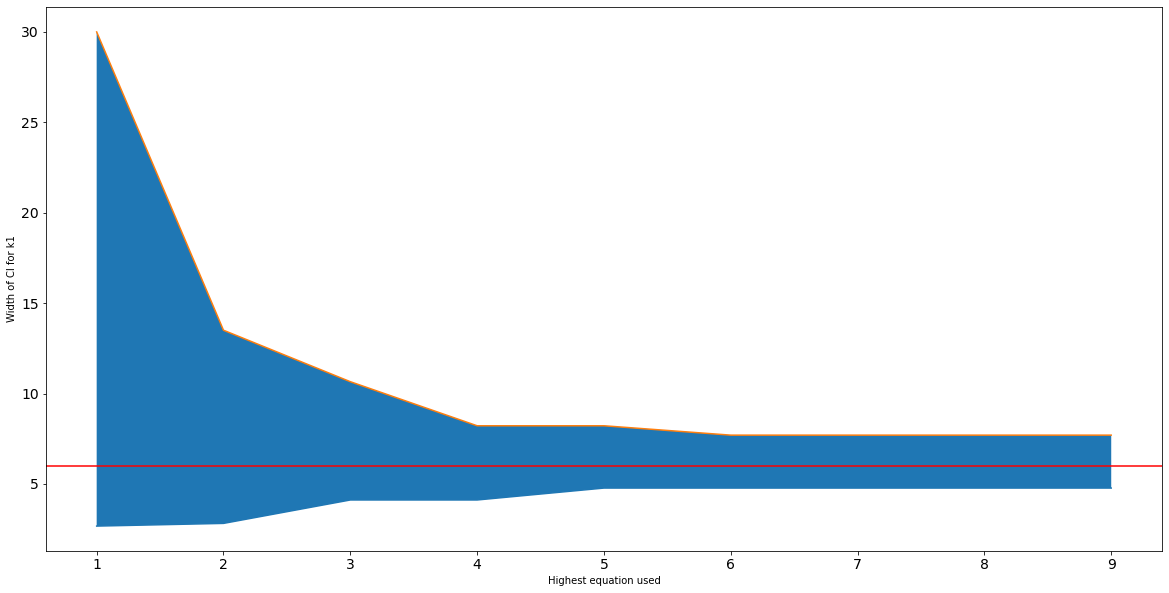

In [99]:
k1 = 6
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(1,10):
    try:
        lb, ub = birth_death_LP([x for x in range(n)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")

Also try starting with e.g. 10th equation, then 9th and 10th equations, ... adding in reverse:

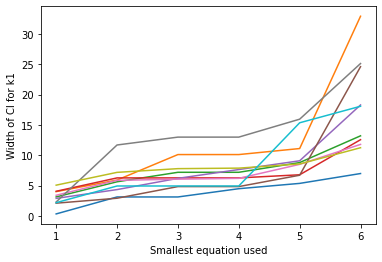

In [49]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(2,8):
        lb, ub = birth_death_LP([8 - x for x in range(n)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(7 - (n-1))
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Smallest equation used")
plt.ylabel("Width of CI for k1")
plt.show()

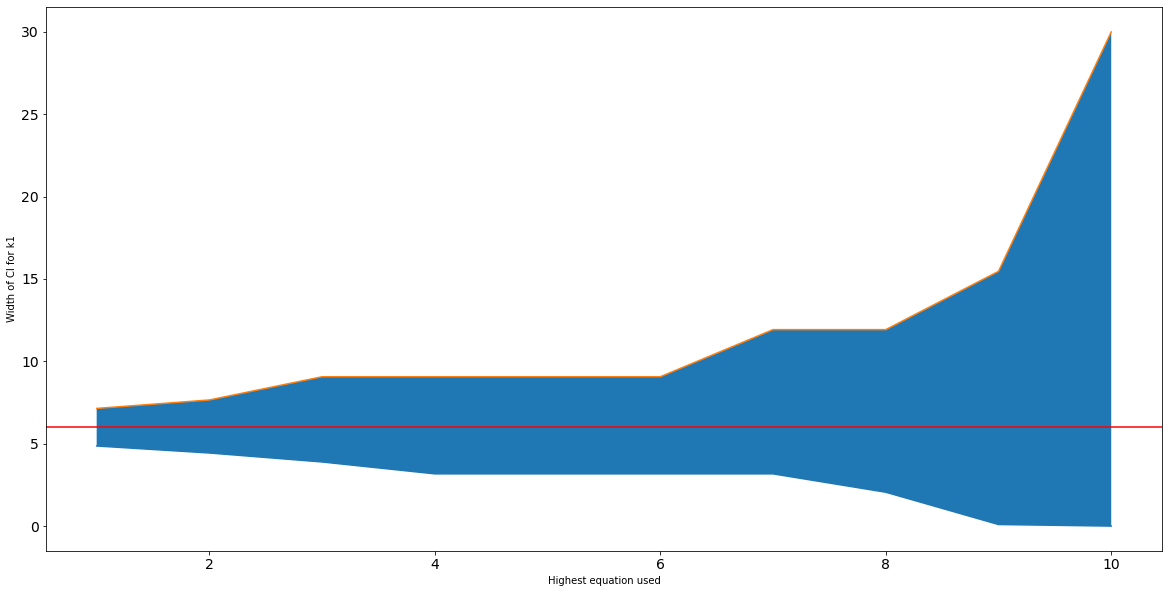

In [100]:
k1 = 6
max_eqn = 10
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(max_eqn,0,-1):
    try:
        lb, ub = birth_death_LP([x for x in range(n,max_eqn + 1)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")